In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from synapseclient import Synapse

username, password = open('/Users/mauliknariya/synapse_login.txt')\
                    .read().splitlines()
syn = Synapse()
syn.login(username, password, silent=True)

#### Datasets: GDSC, CCLE baseline RNAseq, and perturbation RNAseq

In [3]:
# GDSC data, IC50 values
dfgdsc = pd.read_csv(open(syn.get('syn22051024').path))
dfgdsc['IC50'] = dfgdsc['LN_IC50'].apply(lambda x: np.exp(x))

# CCLE baseline RNAseq
dfccle = pd.read_csv(open(syn.get('syn21822697').path), index_col=0)

# Cell lines common between GDSC and CCLE (around 384)
cell_lines = np.intersect1d(dfgdsc['CELL_LINE_NAME'].unique(),
                            dfccle.columns)

# Drugs from perturbation RNAseq from DREAM 2019
dfmeta19 = pd.read_csv(open(syn.get('syn22051003').path))
drugs = np.sort(dfmeta19['compound'].unique())
drugs = np.delete(drugs, np.where(drugs=='DMSO'))
drugs = np.delete(drugs, np.where(drugs=='UNTREATED'))
drugs = [d.lower().capitalize() if str.isalpha(d) is True else d for d in drugs]

#### True ranking of cell lines based on their IC50 values from GDSC data 

In [4]:
dfrank_true = pd.DataFrame(index=cell_lines)
for drug in drugs:
    dfic50 = dfgdsc[(dfgdsc.DRUG_NAME==drug) &
                    (dfgdsc.CELL_LINE_NAME.isin(cell_lines))]\
                   [['CELL_LINE_NAME', 'IC50']]
    if dfic50.empty is True: continue
    dfic50.index = dfic50['CELL_LINE_NAME']
    dfic50 = dfic50.drop(columns='CELL_LINE_NAME')
    dfic50 = dfic50.groupby(dfic50.index).mean()
    dfic50 = dfic50.sort_values(by='IC50', ascending=False)
    rank = pd.Series(np.arange(1, dfic50.shape[0]+1, dtype=int),
                     index=dfic50.index, name=drug)
    dfrank_true = pd.concat([dfrank_true, rank], sort=False, axis=1)
dfrank_true

,Afatinib,AZD5363,Bosutinib,Cabozantinib,Cediranib,Crizotinib,Dasatinib,Foretinib,Gefitinib,Imatinib,Lapatinib,Linifanib,Nilotinib,Osimertinib,Ponatinib,Quizartinib,Sorafenib,Sunitinib
A101D,78.0,265.0,288.0,252.0,176.0,234.0,213.0,268.0,158.0,20.0,203.0,47.0,312.0,52.0,148.0,42.0,186.0,88.0
A172,118.0,155.0,76.0,283.0,313.0,125.0,234.0,284.0,231.0,NaN,246.0,207.0,179.0,213.0,318.0,150.0,271.0,NaN
A204,251.0,195.0,215.0,364.0,325.0,37.0,241.0,364.0,63.0,NaN,58.0,359.0,369.0,209.0,355.0,360.0,318.0,NaN
A2058,93.0,268.0,222.0,66.0,223.0,197.0,84.0,228.0,212.0,NaN,256.0,117.0,227.0,220.0,141.0,137.0,238.0,NaN
A253,255.0,139.0,197.0,42.0,81.0,145.0,203.0,89.0,284.0,35.0,295.0,188.0,206.0,162.0,205.0,120.0,193.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VMRCRCW,346.0,NaN,113.0,281.0,NaN,NaN,NaN,275.0,312.0,NaN,NaN,152.0,276.0,NaN,130.0,171.0,NaN,NaN
WM115,26.0,256.0,21.0,254.0,137.0,95.0,125.0,157.0,77.0,NaN,47.0,244.0,184.0,85.0,84.0,352.0,55.0,NaN
WSUDLCL2,217.0,327.0,243.0,89.0,317.0,203.0,167.0,176.0,198.0,75.0,215.0,247.0,316.0,272.0,99.0,247.0,257.0,51.0
YKG1,58.0,NaN,272.0,268.0,NaN,NaN,NaN,298.0,305.0,NaN,NaN,325.0,306.0,NaN,113.0,193.0,NaN,NaN


#### Predicted ranking for cell lines based on top 5 genes that are highly correlated with IC50 values

In [5]:
from correlation import gdsc_ccle
dfrank_pred = pd.DataFrame(index=dfccle.columns[dfccle.columns.isin(cell_lines)])
for drug in dfrank_true.columns:
    dfcorr = gdsc_ccle(drug)
    dfcorr = dfcorr.dropna()
    dfcorr['rho'] = dfcorr['rho'].apply(lambda x: abs(x))
    dfcorr = dfcorr.sort_values('rho', ascending=False)
    hicorr_genes = np.asarray(dfcorr.head(5).index)
    dfdrug = pd.DataFrame(index=dfccle.columns[dfccle.columns.isin(cell_lines)])
    for gene in hicorr_genes:
        gene_expr = pd.Series(dfccle[dfccle.columns[dfccle.columns.isin(cell_lines)]].loc[gene])
        gene_expr = gene_expr.sort_values(ascending=False)
        rank = pd.Series(np.arange(1, gene_expr.size+1, dtype=int),
                         index=gene_expr.index, name=gene)
        dfdrug = pd.concat([dfdrug, rank], sort=False, axis=1)
    dfrank_pred = pd.concat([dfrank_pred,
                            pd.Series(dfdrug.median(axis=1), name=drug)],
                            sort=False, axis=1)
dfrank_pred

,Afatinib,AZD5363,Bosutinib,Cabozantinib,Cediranib,Crizotinib,Dasatinib,Foretinib,Gefitinib,Imatinib,Lapatinib,Linifanib,Nilotinib,Osimertinib,Ponatinib,Quizartinib,Sorafenib,Sunitinib
A101D,88.0,229.0,151.0,214.0,172.0,186.0,153.0,273.0,89.0,247.0,69.0,250.0,227.0,69.0,101.0,246.0,227.0,79.0
A172,58.0,141.0,86.0,194.0,177.0,164.0,137.0,206.0,39.0,156.0,292.0,102.0,74.0,169.0,255.0,231.0,52.0,73.0
A204,106.0,269.0,232.0,261.0,236.0,172.0,260.0,277.0,201.0,230.0,158.0,323.0,260.0,69.0,301.0,308.0,308.0,148.0
A2058,52.0,131.0,175.0,238.0,133.0,239.0,251.0,225.0,92.0,218.0,161.0,272.0,215.0,102.0,129.0,266.0,201.0,173.0
A253,202.0,312.0,274.0,147.0,187.0,135.0,119.0,136.0,91.0,154.0,321.0,227.0,108.0,279.0,103.0,83.0,172.0,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VMRCRCW,216.0,227.0,193.0,149.0,278.0,129.0,174.0,190.0,233.0,55.0,256.0,128.0,178.0,132.0,310.0,140.0,123.0,244.0
WM115,48.0,196.0,79.0,259.0,171.0,182.0,161.0,307.0,94.0,185.0,52.0,299.0,185.0,22.0,137.0,276.0,185.0,132.0
WSUDLCL2,272.0,336.0,366.0,337.0,354.0,355.0,214.0,289.0,349.0,333.0,336.0,321.0,310.0,347.0,337.0,310.0,354.0,160.0
YKG1,82.0,224.0,84.0,247.0,183.0,203.0,177.0,327.0,54.0,86.0,186.0,279.0,265.0,14.0,102.0,279.0,255.0,77.0


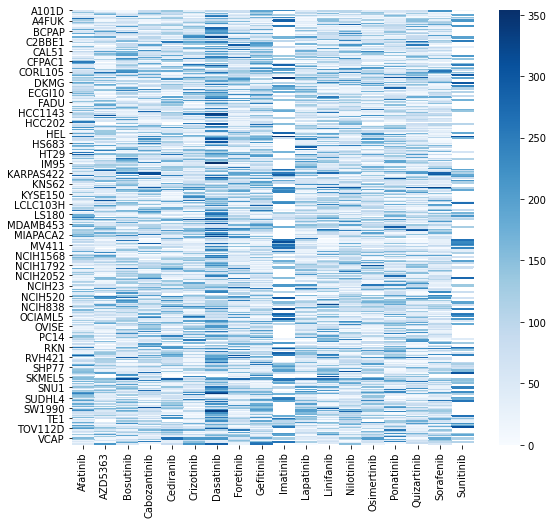

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 8))
sns.heatmap(abs(dfrank_true-dfrank_pred), cmap='Blues')